In [54]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree

In [55]:
def data_results(testing_classes, testing_inputs, alg_class):
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(testing_classes, alg_class.predict(testing_inputs))
    )

    cm_display.plot()
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])
    plt.xlabel('Predicted Entry')
    plt.ylabel('Actual Entry')
    plt.show()

    print(classification_report(testing_classes, alg_class.predict(testing_inputs)))

rank                   0
playoff                0
won                    0
PER                    0
Cumulative Win Rate    0
dtype: int64
Empty DataFrame
Columns: [year, PER, coachID, Cumulative Win Rate, playoff, playoffNextYear]
Index: []
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Feature: rank, Importance: 0.09343390475573521
Feature: playoff, Importance: 0.0
Feature: won, Importance: 0.053088736670278365
Feature: PER, Importance: 0.6462538448746662
Feature: Cumulative Win Rate, Importance: 0.20722351369932038
3.410691003911343


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_6960\395601012.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['predict'] = probs
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_6960\395601012.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])


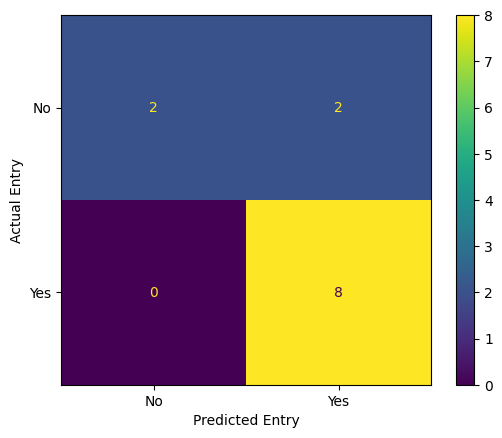

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



In [56]:
df_teams = pd.read_csv('dataset/processed/teams_test.csv')
df_teams = df_teams.sort_values(by=['franchID', 'year'])
df_teams['playoffNextYear'] = df_teams['playoff'].shift(-1)
df_teams.loc[df_teams['franchID'] != df_teams['franchID'].shift(-1), 'playoffNextYear'] = None
df_teams.dropna(subset=['playoffNextYear'], inplace=True)
#df_teams["confW"] = df_teams["confW"].fillna(0)
#df_teams = df_teams.fillna(-1)
label_encoder = LabelEncoder()
df_teams['tmID'] = label_encoder.fit_transform(df_teams['tmID'])
df_teams['playoff'] = label_encoder.fit_transform(df_teams['playoff'])
df_teams['playoffNextYear'] = label_encoder.fit_transform(df_teams['playoffNextYear'])
features = ['rank', 'playoff', 'won', 'PER', 'Cumulative Win Rate'] # attend?

df_teams_train = df_teams[df_teams['year'] <= 9]
df_teams_test = df_teams[df_teams['year'].isin([10])]
# df_teams_train = df_teams[df_teams['year'] <= 5]
# df_teams_test = df_teams[df_teams['year'].isin([6])]

training_inputs = df_teams_train[features]
training_classes = df_teams_train['playoffNextYear']
testing_inputs = df_teams_test[features]
testing_classes = df_teams_test['playoffNextYear']
print(training_inputs.isna().sum())
print(df_teams_train[df_teams_train['tmID'] == "CHA"][['year', 'PER', 'coachID', 'Cumulative Win Rate', 'playoff', 'playoffNextYear']])

dt_class = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_class,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(training_inputs, training_classes)
# print(training_inputs.isna().sum())

best_model = grid_search.best_estimator_
best_model.predict(testing_inputs)

best_model.score(testing_inputs, testing_classes)
accuracy_score(testing_classes, best_model.predict(testing_inputs))
importance = best_model.feature_importances_
for feature, imp in zip(features, importance):
    print(f"Feature: {feature}, Importance: {imp}")

'''f = open("results.txt", "a")
f.write("Year 9 Accuracy = " + str(accuracy_score(testing_classes, dt_class.predict(testing_inputs))) + "\n")
f.close()'''

probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())

data_results(testing_classes, testing_inputs, best_model)

# plot_tree(dt_class, feature_names=features, filled=True)

In [ ]:
rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(training_inputs, training_classes)

# print(rf_class.predict_proba(training_inputs))

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

'''grid_search = GridSearchCV(estimator=rf_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
best_model.predict(testing_inputs)

best_model.score(testing_inputs, testing_classes)

# rf_class.fit(training_inputs, training_classes)
probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
df_teams_test['predict'] = probs
df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])
print(df_teams_test['result'].sum())'''
accuracy_score(testing_classes, best_model.predict(testing_inputs))

data_results(testing_classes, testing_inputs, best_model)

KeyboardInterrupt: 

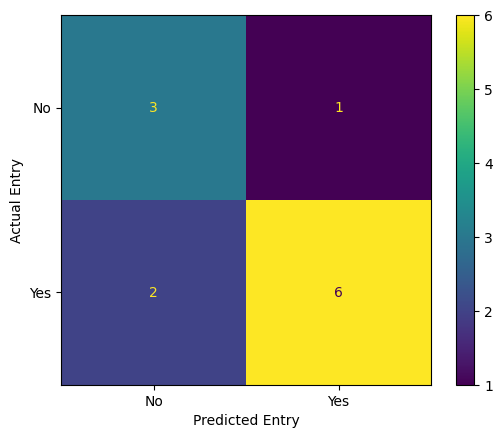

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.86      0.75      0.80         8

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



In [ ]:
nb_class = GaussianNB()
nb_class.fit(training_inputs, training_classes)

nb_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, nb_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, nb_class)

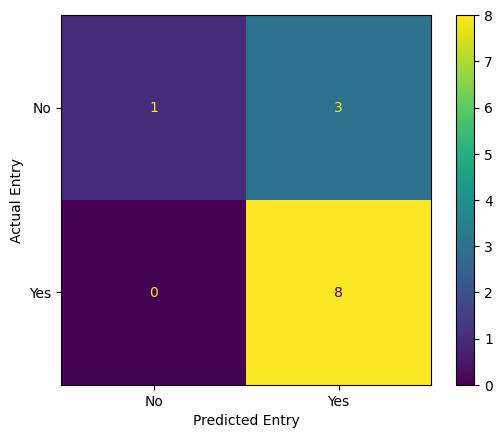

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.73      1.00      0.84         8

    accuracy                           0.75        12
   macro avg       0.86      0.62      0.62        12
weighted avg       0.82      0.75      0.69        12



In [ ]:
svm_class = SVC(kernel='rbf', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [1, 0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(estimator=svm_class, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(training_inputs, training_classes)
best_model = grid_search.best_estimator_
accuracy_score(testing_classes, best_model.predict(testing_inputs))

'''f = open("results.txt", "a")
f.write("Year 9 Accuracy = " + str(accuracy_score(testing_classes, dt_class.predict(testing_inputs))) + "\n")
f.close()'''

#best_model.fit(training_inputs, training_classes)
#probs = [pred[1] for pred in best_model.predict_proba(testing_inputs)]
#df_teams_test['predict'] = probs
#df_teams_test['result'] = abs(df_teams_test['predict'] - df_teams_test['playoffNextYear'])
#print(df_teams_test['result'].sum())

data_results(testing_classes, testing_inputs, best_model)

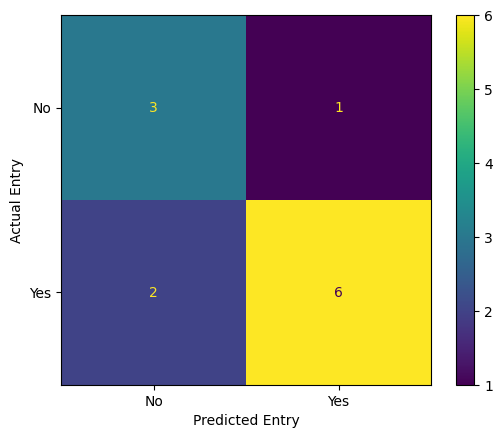

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.86      0.75      0.80         8

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



In [ ]:
knn_class = KNeighborsClassifier(n_neighbors=13, algorithm='auto', metric='minkowski', p=1, weights='distance')

'''param_grid = {
        'n_neighbors': np.arange(2, 30, 1),
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]
}
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
knn_cv = GridSearchCV(knn_class, param_grid=param_grid, cv=kf, verbose=1)
knn_cv.fit(training_inputs, training_classes)
print(knn_cv.best_params_)'''

knn_class.fit(training_inputs, training_classes)

knn_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, knn_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, knn_class)

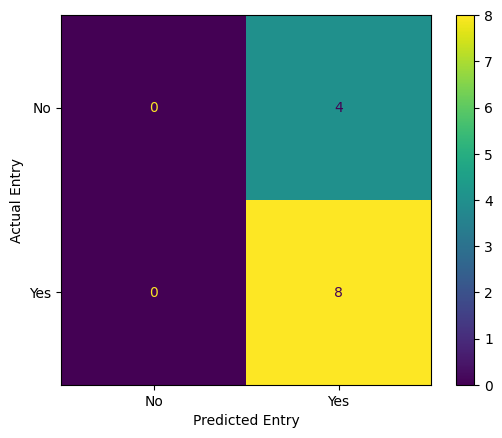

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.67      1.00      0.80         8

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [ ]:
ann_class = MLPClassifier(random_state=42, max_iter=300)
ann_class.fit(training_inputs, training_classes)

ann_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ann_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ann_class)

In [ ]:
ab_class = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)
'''param_grid = {
        'n_estimators': np.arange(10, 100, 10),
        'algorithm': ['SAMME', 'SAMME.R'],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
ab_cv = GridSearchCV(ab_class, param_grid=param_grid, cv=kf, verbose=1)
ab_cv.fit(training_inputs, training_classes)
print(ab_cv.best_params_)'''

#ab_class.score(testing_inputs, testing_classes)

#accuracy_score(testing_classes, ab_class.predict(testing_inputs))

#data_results(testing_classes, testing_inputs, ab_class)

"param_grid = {\n        'n_estimators': np.arange(10, 100, 10),\n        'algorithm': ['SAMME', 'SAMME.R'],\n        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]\n}\nkf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)\nab_cv = GridSearchCV(ab_class, param_grid=param_grid, cv=kf, verbose=1)\nab_cv.fit(training_inputs, training_classes)\nprint(ab_cv.best_params_)"

In [ ]:
'''for w in df_teams['confW']:
    print(w)
nan_count = df_teams['confW'].isna().sum()
print(nan_count)'''

#print(df_teams.isna().sum())

#df_teams.head(164)

df_teams.head(30)

,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,homeL,awayW,awayL,confW,confL,min,PER,coachID,Cumulative Win Rate,playoffNextYear
0,9,0,ATL,EA,7,0,NaN,NaN,NaN,Atlanta Dream,...,16,3,14,2,18,6825,3.160357,meadoma99w,0.117647,1
1,10,0,ATL,EA,2,1,L,NaN,NaN,Atlanta Dream,...,5,6,11,10,12,6950,3.313946,meadoma99w,0.308824,1
2,1,1,CHA,EA,8,0,NaN,NaN,NaN,Charlotte Sting,...,11,3,13,5,16,6475,3.152351,dunntr01wc,0.281250,1
3,2,1,CHA,EA,4,1,W,W,L,Charlotte Sting,...,5,7,9,15,6,6500,3.357608,donovan99w,0.415625,1
4,3,1,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,5,7,9,12,9,6450,3.222922,donovan99w,0.513779,1
5,4,1,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,4,5,12,12,12,6850,3.168911,laceytr99w,0.500000,0
6,5,1,CHA,EA,5,0,NaN,NaN,NaN,Charlotte Sting,...,7,6,11,8,12,6900,3.259226,laceytr99w,0.485294,0
7,6,1,CHA,EA,6,0,NaN,NaN,NaN,Charlotte Sting,...,12,1,16,4,16,6945,3.050083,laceytr99w,0.513779,0
9,7,2,CHI,EA,7,0,NaN,NaN,NaN,Chicago Sky,...,14,2,15,4,16,6800,3.116197,cowenda01w,0.513779,0
10,8,2,CHI,EA,6,0,NaN,NaN,NaN,Chicago Sky,...,11,8,9,6,14,6972,3.140279,overtbo99w,0.513779,0
